### ***--> Installing the required libraries***

In [20]:
pip install pandas matplotlib seaborn prophet scikit-learn

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

### ***--> Loading Daily Data***

In [22]:
daily_data = pd.read_csv("/content/SN_d_tot_V2.0.csv", delimiter=';', header=None)
daily_data.columns = ["Year", "Month", "Day", "FractionalYear", "SunspotNumber", "StdDev", "Observations", "Indicator"]
daily_data = daily_data[daily_data["SunspotNumber"] != -1]  # Remove missing values
daily_data['Date'] = pd.to_datetime(daily_data[['Year', 'Month', 'Day']])
daily_data = daily_data[['Date', 'SunspotNumber']].rename(columns={'Date': 'ds', 'SunspotNumber': 'y'})

###***--> Preprocess the data***

In [23]:
daily_data['y'] = daily_data['y'] + 1  # Add small constant to handle zeros
daily_data = daily_data.dropna()  # Drop remaining invalid rows

###***--> Training the FBProphet Model***

In [24]:
# Initialize Prophet Model
daily_model = Prophet()

# Fit the model
daily_model.fit(daily_data)

# Create future dataframe (365 days)
future_daily = daily_model.make_future_dataframe(periods=365)

# Predict
forecast_daily = daily_model.predict(future_daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6n3zt9wa/r9qhdk95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6n3zt9wa/7apn0cys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21807', 'data', 'file=/tmp/tmp6n3zt9wa/r9qhdk95.json', 'init=/tmp/tmp6n3zt9wa/7apn0cys.json', 'output', 'file=/tmp/tmp6n3zt9wa/prophet_modelly97gtyt/prophet_model-20241127231641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:16:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:17:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


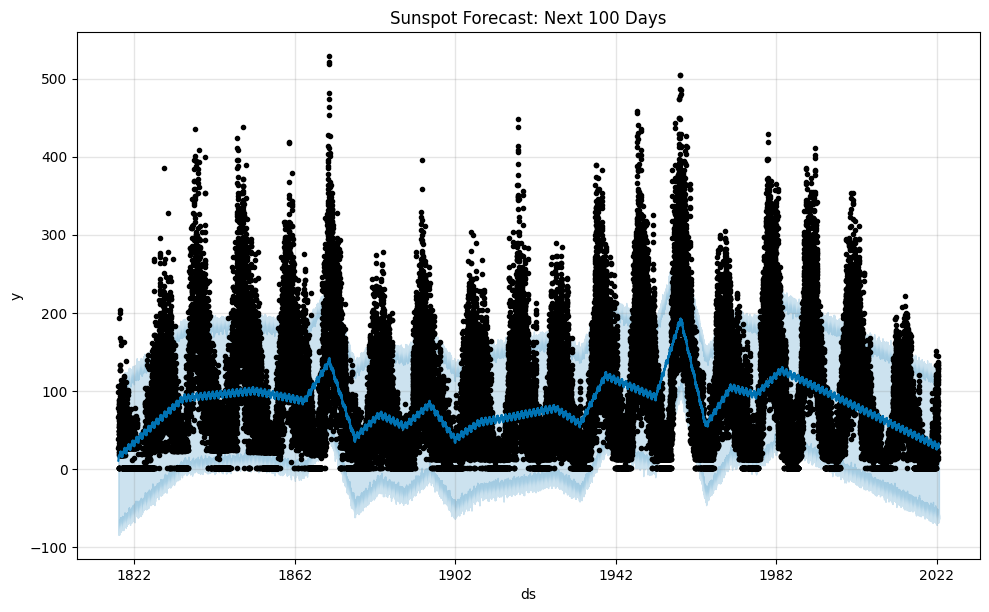

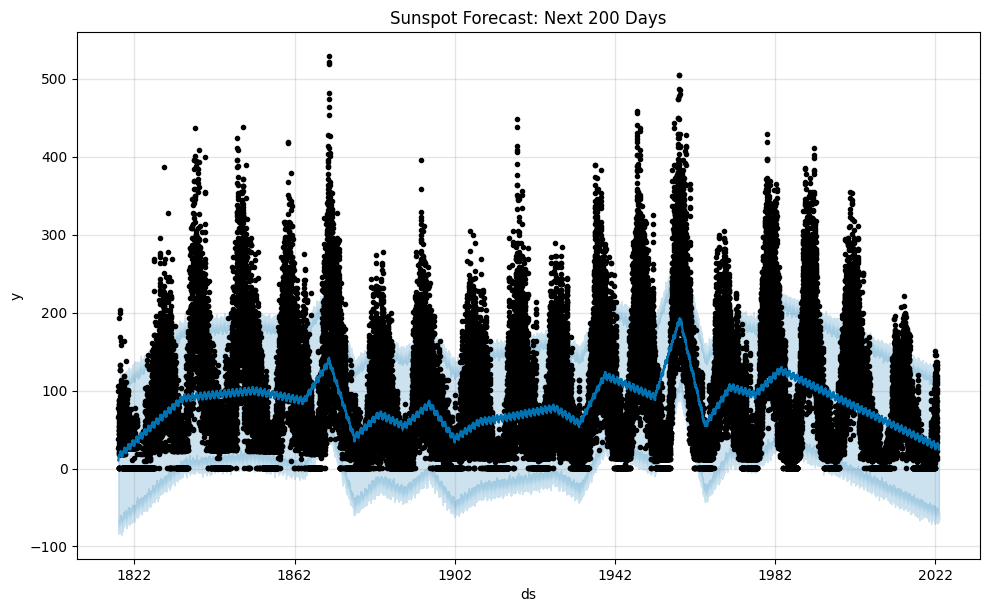

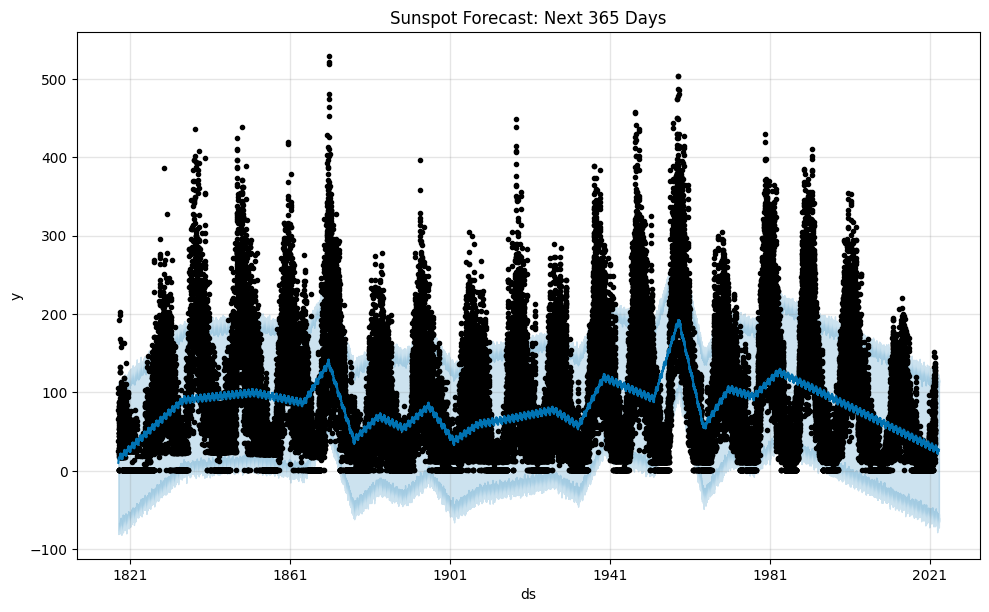

In [25]:
# Predict for 100, 200, and 365 days
future_daily_100 = daily_model.make_future_dataframe(periods=100)
future_daily_200 = daily_model.make_future_dataframe(periods=200)
future_daily_365 = daily_model.make_future_dataframe(periods=365)

# Predict 100 days
forecast_daily_100 = daily_model.predict(future_daily_100)

# Predict 200 days
forecast_daily_200 = daily_model.predict(future_daily_200)

# Predict 365 days
forecast_daily_365 = daily_model.predict(future_daily_365)

# Visualize predictions for each forecast
fig_100 = daily_model.plot(forecast_daily_100)
plt.title("Sunspot Forecast: Next 100 Days")
plt.show()

fig_200 = daily_model.plot(forecast_daily_200)
plt.title("Sunspot Forecast: Next 200 Days")
plt.show()

fig_365 = daily_model.plot(forecast_daily_365)
plt.title("Sunspot Forecast: Next 365 Days")
plt.show()

In [26]:
# For 100 days prediction
print("Predicted values for the next 100 days:")
print(forecast_daily_100[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

# For 200 days prediction
print("Predicted values for the next 200 days:")
print(forecast_daily_200[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(200))

# For 365 days prediction
print("Predicted values for the next 365 days:")
print(forecast_daily_365[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(365))

Predicted values for the next 100 days:
              ds       yhat  yhat_lower  yhat_upper
71383 2022-05-01  29.595705  -59.423996  125.864232
71384 2022-05-02  29.921329  -68.845883  119.142889
71385 2022-05-03  29.976983  -57.516863  117.467550
71386 2022-05-04  30.207301  -52.209695  119.371349
71387 2022-05-05  30.226707  -59.620885  120.303701
...          ...        ...         ...         ...
71478 2022-08-04  28.646186  -64.880973  111.468772
71479 2022-08-05  28.595873  -64.907418  111.166064
71480 2022-08-06  29.027088  -58.337234  116.688687
71481 2022-08-07  29.253978  -63.295677  124.549292
71482 2022-08-08  29.756231  -52.791441  126.757206

[100 rows x 4 columns]
Predicted values for the next 200 days:
              ds       yhat  yhat_lower  yhat_upper
71383 2022-05-01  29.595705  -58.077075  120.474239
71384 2022-05-02  29.921329  -64.173341  117.409816
71385 2022-05-03  29.976983  -65.784018  117.956557
71386 2022-05-04  30.207301  -57.275350  122.824789
71387 2022-0

###***--> Visualizing Predictions***

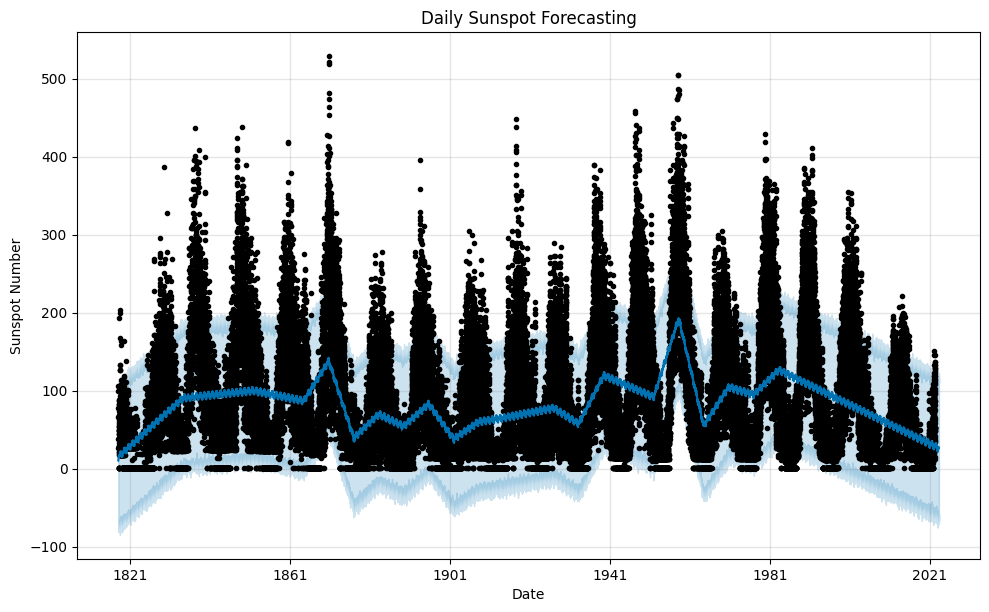

In [27]:
fig = daily_model.plot(forecast_daily)
plt.title("Daily Sunspot Forecasting")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.show()

### ***--> Tune Hyperparameters : Adding custom seasonality***

In [28]:
daily_model = Prophet(
    growth='linear',
    changepoint_prior_scale=0.05,   # Restrict sensitivity to changes
    seasonality_prior_scale=10,    # Adjust seasonality strength
    seasonality_mode='multiplicative'
)
daily_model.add_seasonality(name='solar_cycle', period=365.25 * 11, fourier_order=5)  # Solar cycle
daily_model.add_seasonality(name='half_cycle', period=365.25 * 5.5, fourier_order=3)  # Half solar cycle

# Fit and Predict again
daily_model.fit(daily_data)
forecast_daily = daily_model.predict(future_daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6n3zt9wa/s20i27yp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6n3zt9wa/hfill7h_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87344', 'data', 'file=/tmp/tmp6n3zt9wa/s20i27yp.json', 'init=/tmp/tmp6n3zt9wa/hfill7h_.json', 'output', 'file=/tmp/tmp6n3zt9wa/prophet_modelk19abknu/prophet_model-20241127232046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


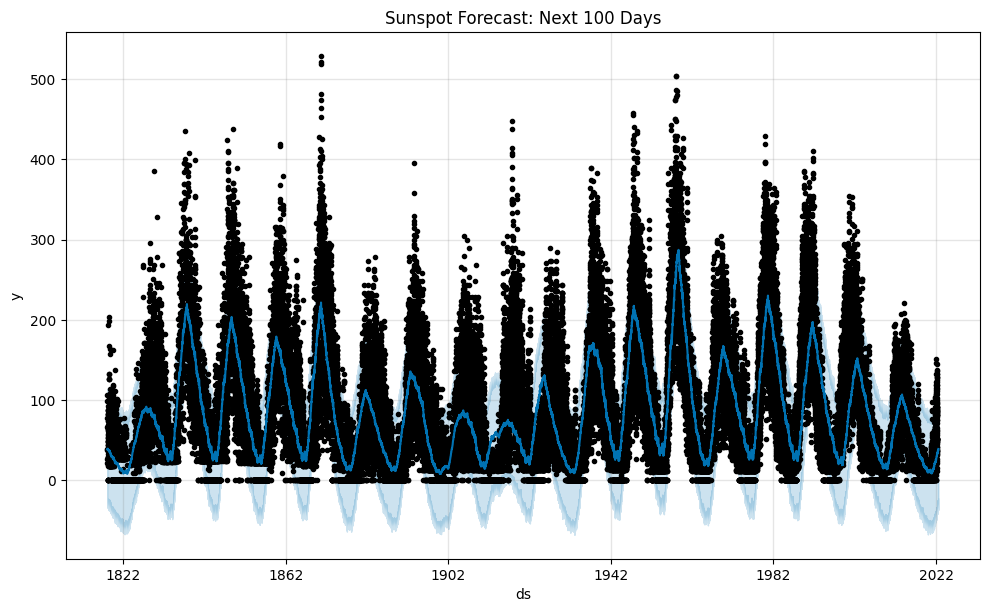

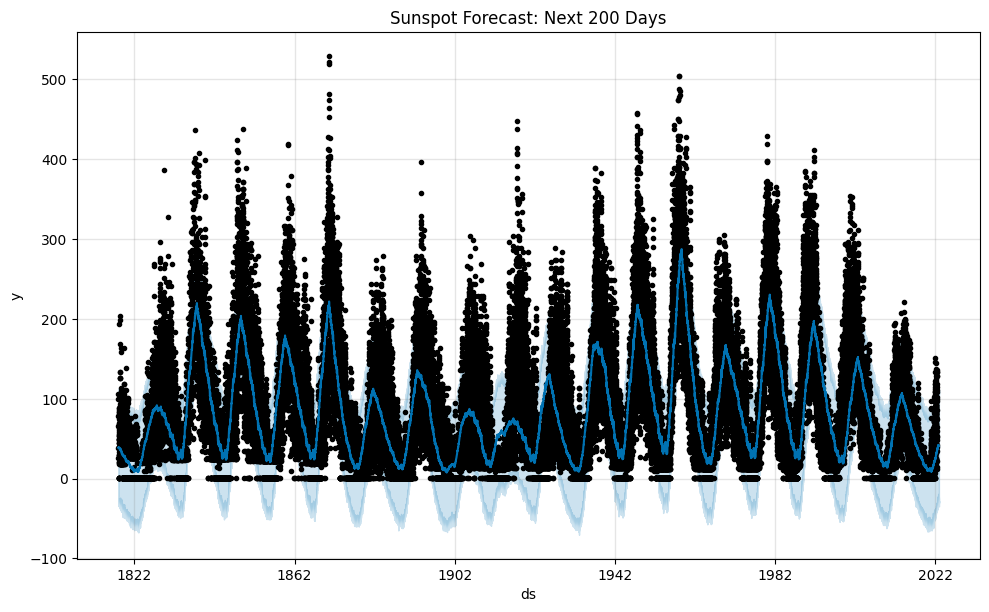

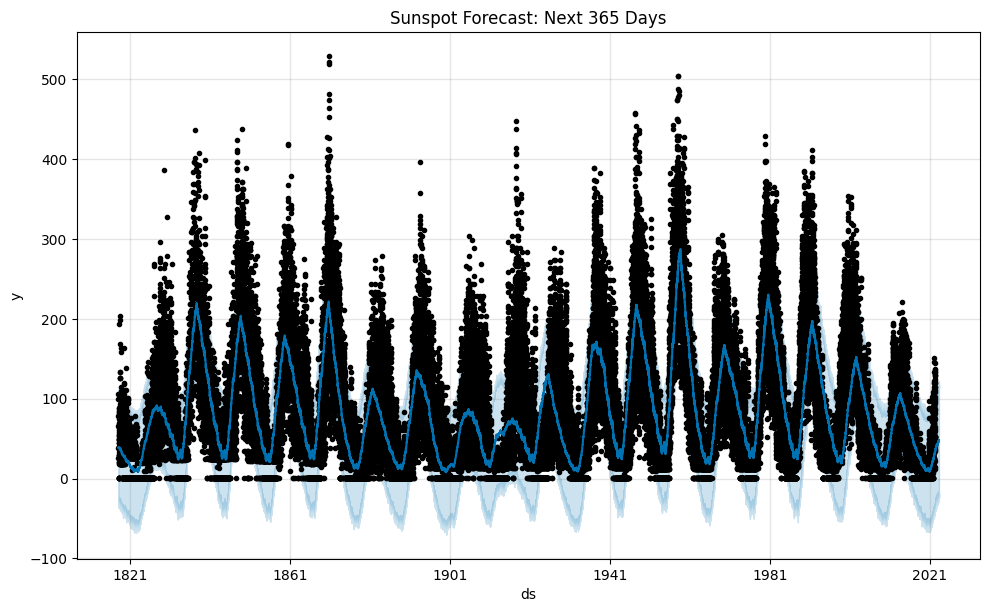

In [30]:
# Predict for 100, 200, and 365 days
future_daily_100 = daily_model.make_future_dataframe(periods=100)
future_daily_200 = daily_model.make_future_dataframe(periods=200)
future_daily_365 = daily_model.make_future_dataframe(periods=365)

# Predict 100 days
forecast_daily_100 = daily_model.predict(future_daily_100)

# Predict 200 days
forecast_daily_200 = daily_model.predict(future_daily_200)

# Predict 365 days
forecast_daily_365 = daily_model.predict(future_daily_365)

# Visualize predictions for each forecast
fig_100 = daily_model.plot(forecast_daily_100)
plt.title("Sunspot Forecast: Next 100 Days")
plt.show()

fig_200 = daily_model.plot(forecast_daily_200)
plt.title("Sunspot Forecast: Next 200 Days")
plt.show()

fig_365 = daily_model.plot(forecast_daily_365)
plt.title("Sunspot Forecast: Next 365 Days")
plt.show()

In [31]:
# For 100 days prediction
print("Predicted values for the next 100 days:")
print(forecast_daily_100[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

# For 200 days prediction
print("Predicted values for the next 200 days:")
print(forecast_daily_200[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(200))

# For 365 days prediction
print("Predicted values for the next 365 days:")
print(forecast_daily_365[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(365))

Predicted values for the next 100 days:
              ds       yhat  yhat_lower  yhat_upper
71383 2022-05-01  33.591575  -33.651968  102.003869
71384 2022-05-02  33.839794  -33.656671  105.324872
71385 2022-05-03  33.923985  -32.872389  100.565221
71386 2022-05-04  34.040125  -38.553748  101.852583
71387 2022-05-05  34.266902  -36.245090  102.907582
...          ...        ...         ...         ...
71478 2022-08-04  38.358891  -31.862617  110.396361
71479 2022-08-05  38.336471  -30.469558  107.834780
71480 2022-08-06  38.582643  -29.689805  104.810136
71481 2022-08-07  38.725666  -22.781750  109.373889
71482 2022-08-08  39.054128  -33.445719  107.811959

[100 rows x 4 columns]
Predicted values for the next 200 days:
              ds       yhat  yhat_lower  yhat_upper
71383 2022-05-01  33.591575  -33.260751  105.722146
71384 2022-05-02  33.839794  -34.344904  103.737501
71385 2022-05-03  33.923985  -33.284737  103.725510
71386 2022-05-04  34.040125  -37.014138  102.990539
71387 2022-0

###***--> Evaluating Model Performance***

In [29]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
# Evaluate using proper y_true and y_pred alignment
y_true = daily_data['y']
y_pred = forecast_daily['yhat'][:len(y_true)]

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.3f}")

MAE: 40.29, MAPE: 6.14, R²: 0.520
